# Genius Song Lyrics
```
@author Carlos Alarcón
@author Rubén Martínez
@course Natural Language Processing
@version 2025
```
Notebook for the final project of _Natural Language Processing_.

The dataset can be found [here](https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information). 

### Install dependencies
First of all, we install the necessary dependencies.

In [1]:
!python -m pip install -q --upgrade pip
!pip install -q kagglehub pandas matplotlib nltk tqdm seaborn

### Import modules
Once installed, we can proceed to import the required modules.

In [2]:
import os
import shutil
import re
import nltk
import kagglehub
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

D:\Users\Rubén\Repositories\nlp\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
from collections import Counter
from tqdm import tqdm
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.classify import NaiveBayesClassifier
from nltk.metrics import ConfusionMatrix

### Load dataset
We then download the dataset from Kaggle. Note that this is done only once since the `dataset_download()` method first checks if the dataset is already downloaded, so it is safe to run it more than once.

In [5]:
path = kagglehub.dataset_download("carlosgdcj/genius-song-lyrics-with-language-information")
print(path)

C:\Users\ruben\.cache\kagglehub\datasets\carlosgdcj\genius-song-lyrics-with-language-information\versions\1


After downloading the dataset, we load the corresponding `csv` file into a `pandas` dataframe in order to handle the data more easily. Immediately after, we show the first rows of the dataset so that we can see how it is.

In [6]:
filepath = os.path.join(path, "song_lyrics.csv")
df = pd.read_csv(filepath)
df.head()

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en


### Visualise data
Let's visualise the data we have in order to gain a better understanding of the information we are dealing with. According to the dataset description, the columns are defined as follows.

| Column         | Meaning                                                                                                   |
|----------------|-----------------------------------------------------------------------------------------------------------|
| title          | Title of the piece. Most entries are songs, but there are also some books, poems and even some other stuff|
| tag            | Genre of the piece. Most non-music pieces are "misc", but not all. Some songs are also labeled as "misc"  |
| artist         | Person or group the piece is attributed to                                                                |
| year           | Release year                                                                                              |
| views          | Number of page views                                                                                      |
| features       | Other artists that contributed                                                                            |
| lyrics         | Lyrics                                                                                                    |
| id             | Genius identifier                                                                                         |
| language_cld3  | Lyrics language according to CLD3. Not reliable results are NaN                                           |
| language_ft    | Lyrics language according to FastText's langid. Values with low confidence (<0.5) are NaN                 |
| language       | Combines language_cld3 and language_ft. Only has a non NaN entry if they both "agree"                     |

#### Music Genres Distribution and Songs per Decade

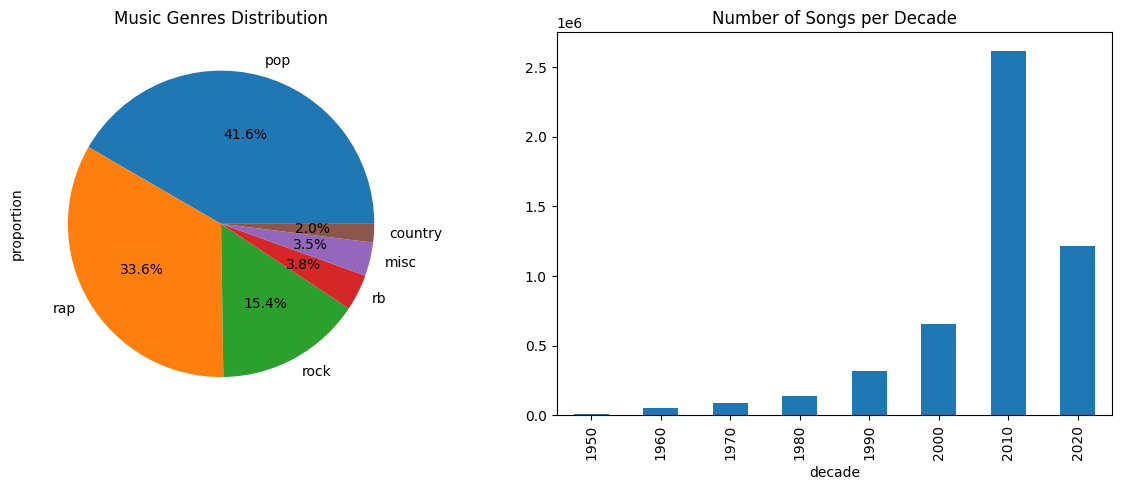

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

tag_counts = df["tag"].value_counts(normalize=True)
tag_counts.plot(kind="pie", autopct='%1.1f%%', ax=axes[0], title="Music Genres Distribution")

df['decade'] = (df['year'] // 10) * 10
decade_counts = df['decade'].value_counts()
decade_counts[decade_counts > 10000].sort_index().plot(kind="bar", ax=axes[1], title="Number of Songs per Decade")

plt.tight_layout()
plt.savefig("distribution.png", dpi=300, bbox_inches='tight')
plt.show()

#### Songs per Language

In [8]:
language_counts = df["language"].value_counts()
print(language_counts)

language
en    3374198
es     275432
fr     189436
pt     167947
ru     166044
       ...   
mt          5
uz          4
tg          3
bs          1
gu          1
Name: count, Length: 84, dtype: int64


#### Songs per Artist

In [9]:
artist_counts = df["artist"].value_counts()
print(artist_counts)

artist
Genius Romanizations             16325
Genius English Translations      13832
Genius Brasil Tradues             8693
Genius Traducciones al Espaol     7083
Genius Traductions Franaises      4680
                                 ...  
Lee Emcee                            1
Vlegels                              1
Knxten, creature (rus)               1
First Class Lyrics                   1
John P. Barlow                       1
Name: count, Length: 641349, dtype: int64


### Data Preprocessing
While there is a wide range of songs in various languages, this project will focus exclusively on English-language songs. To do so, we first need to get rid of all the songs whose language is not English. Also, since the `misc` category does not fit neatly into a standard genre, we will discard the miscellaneous songs as well. Finally, we will take only the songs from the 1960s to now.

In [10]:
df = df[df["language"] == "en"]
df = df[df["tag"] != "misc"]
df = df[df["decade"] >= 1960]

Now that all the songs are in English, what really matters is the _lyrics_ column, which has the text with which we will be able to do NLP tasks. Nevertheless, we need to do some data cleaning before we start. The aforementioned column has several annotations on every column of it. For instance, let's take a look at the most viewed (thus listened) song of Bob Dylan, which is _Blowin' in the Wind_.

In [11]:
df[df["artist"] == "Bob Dylan"].sort_values(by="views", ascending=False)[:1]

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language,decade
73400,Blowin in the Wind,rock,Bob Dylan,1963,483763,{},[Verse 1]\nHow many roads must a man walk down...,79424,en,en,en,1960


As shown below, the lyrics have annotations in square brackets.

In [12]:
lyrics = df[df["artist"] == "Bob Dylan"].sort_values(by="views", ascending=False)[:1]["lyrics"].tolist()
print(lyrics[0])

[Verse 1]
How many roads must a man walk down
Before you call him a man?
How many seas must the white dove sail
Before she sleeps in the sand?
Yes, and how many times must the cannonballs fly
Before they're forever banned?

[Refrain]
The answer, my friend, is blowin' in the wind
The answer is blowin' in the wind

[Verse 2]
Yes, and how many years can a mountain exist
'Fore it is washed to the sea?
Yes, and how many years can some people exist
Before they're allowed to be free?
Yes, and how many times can a man turn his head
And pretend that he just doesn't see?

[Refrain]
The answer, my friend, is blowin' in the wind
The answer is blowin' in the wind
[Verse 3]
Yes, and how many times must a man look up
Before he can see the sky?
Yes, and how many ears must one man have
Before he can hear people cry?
Yes, and how many deaths will it take till he knows
That too many people have died?

[Refrain]
The answer, my friend, is blowin' in the wind
The answer is blowin' in the wind


Although these annotations are essential for understanding the full meaning of the song, we will remove them because they do not reflect the actual language used in the lyrics.

In [13]:
df["lyrics"] = df["lyrics"].str.replace(r"\[.*?\]", "", regex=True)

Returning to the Bob Dylan example, we can now see that the annotations have been successfully removed.

In [14]:
lyrics = df[df["artist"] == "Bob Dylan"].sort_values(by="views", ascending=False)[:1]["lyrics"].tolist()
print(lyrics[0])


How many roads must a man walk down
Before you call him a man?
How many seas must the white dove sail
Before she sleeps in the sand?
Yes, and how many times must the cannonballs fly
Before they're forever banned?


The answer, my friend, is blowin' in the wind
The answer is blowin' in the wind


Yes, and how many years can a mountain exist
'Fore it is washed to the sea?
Yes, and how many years can some people exist
Before they're allowed to be free?
Yes, and how many times can a man turn his head
And pretend that he just doesn't see?


The answer, my friend, is blowin' in the wind
The answer is blowin' in the wind

Yes, and how many times must a man look up
Before he can see the sky?
Yes, and how many ears must one man have
Before he can hear people cry?
Yes, and how many deaths will it take till he knows
That too many people have died?


The answer, my friend, is blowin' in the wind
The answer is blowin' in the wind


### Visualise data again
Since we have preprocessed the original data, let's now take a look at the current one.

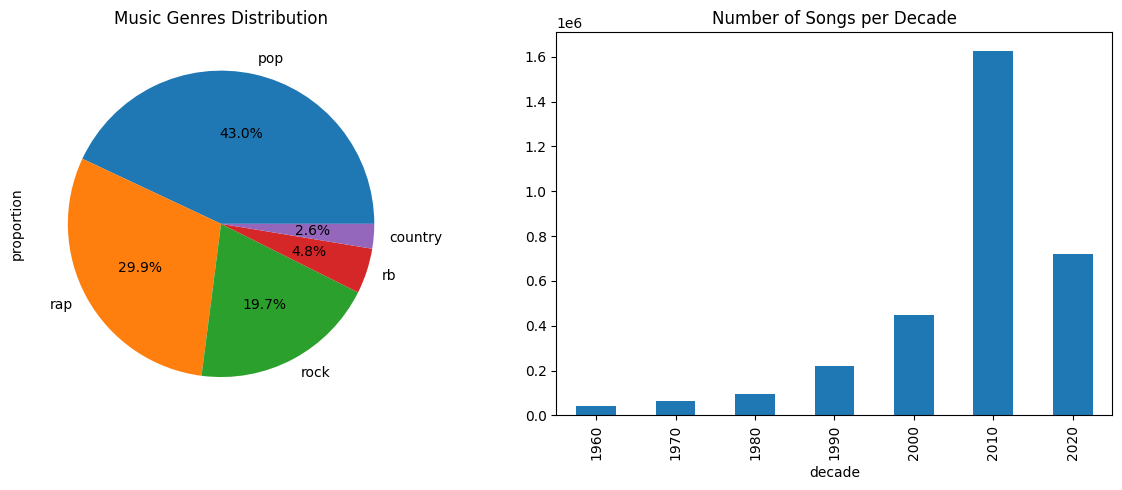

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

tag_counts = df["tag"].value_counts(normalize=True)
tag_counts.plot(kind="pie", autopct='%1.1f%%', ax=axes[0], title="Music Genres Distribution")

df['decade'] = (df['year'] // 10) * 10
decade_counts = df['decade'].value_counts()
decade_counts[decade_counts > 10000].sort_index().plot(kind="bar", ax=axes[1], title="Number of Songs per Decade")

plt.tight_layout()
plt.savefig("distribution2.png", dpi=300, bbox_inches='tight')
plt.show()

As we can observe above, the distribution of music genres and the number of songs per decade is very similar to the one of the original dataset, given that the majority of the original songs were in English.

### Create the corpus
Let's build a text corpus using the lyrics of the songs. For now, we'll organize it as a categorized corpus, grouping lyrics by their corresponding genres.

In [16]:
n_songs = 10000
seed = 2025 # for reproducibility
corpus_df = df.dropna(subset=["tag", "lyrics"]).sample(n=n_songs, random_state=seed).astype(str)

Since we will be using `nltk` for NLP tasks, we need to save the lyrics as files so they can be read later using a `CorpusReader`.

In [17]:
corpus_root = "corpus"

if os.path.exists(corpus_root):
    shutil.rmtree(corpus_root)

os.makedirs(corpus_root, exist_ok=True)

for i, (genre, lyric) in tqdm(enumerate(zip(corpus_df["tag"], corpus_df["lyrics"])), total=len(corpus_df), desc="Writing corpus"):
    genre_dir = os.path.join(corpus_root, genre)
    os.makedirs(genre_dir, exist_ok=True)
    file_path = os.path.join(genre_dir, f"{i:0{len(str(n_songs))+1}}.txt")
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(lyric)

Writing corpus: 100%|██████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.21it/s]


Now we are ready to load the corpus. To do so, we use the class `CategorizedPlaintextCorpusReader` from `nltk`.

In [18]:
lyrics = CategorizedPlaintextCorpusReader(
    root=corpus_root,
    fileids=r".*\.txt",
    cat_pattern=r"([^/.]+)/.*",
)

Let's verify that everything was loaded correctly. As an example, we will plot the corpus categories and display the first 10 words from the `rock` genre.

In [19]:
print(lyrics.categories())
print(lyrics.words(categories='rock')[:10])

['country', 'pop', 'rap', 'rb', 'rock']
['Ancient', 'One', 'An', 'entity', 'from', 'an', 'outer', 'world', 'Malignant', 'lifeform']


### Exploratory Analysis

#### Vocabulary
Let us first count the number of word tokens that are in the corpus, in addition to the to the number of wordforms.

In [20]:
print(f"Word tokens: {len(lyrics.words())}")
print(f"Wordforms: {len(set(lyrics.words()))}")

Word tokens: 3417898
Wordforms: 64270


So we see that the corpus is built on top of 3,417,898 word tokens of a vocabulary with 64,270 different wordforms. Since the number of wordforms is significantly lower than the total number of word tokens, it is interesting to see what is the lexical diversity of the corpus.

In [21]:
def lexical_diversity(text):
    return len(set(text)) / len(text)

In [22]:
print(f"Lexical diversity: {round(100 * lexical_diversity(lyrics.words()), 2)}%")

Lexical diversity: 1.88%


A lexical diversity of approximately 2% indicates that, on average, each unique word appears 50 times. Let us now examine how this measure varies across different musical genres.

In [23]:
table = []
for genre in lyrics.categories():
    words = lyrics.words(categories=genre)
    word_tokens = len(words)
    wordforms = len(set(words))
    diversity = round(lexical_diversity(words), 2)
    table.append([genre, word_tokens, wordforms, diversity])

df2 = pd.DataFrame(table, columns=["Genre", "Word tokens", "Wordforms", "Lexical diversity"])
print(df2)

     Genre  Word tokens  Wordforms  Lexical diversity
0  country        77387       5536               0.07
1      pop      1168779      30057               0.03
2      rap      1531379      46768               0.03
3       rb       183176       8491               0.05
4     rock       457177      19366               0.04


We now examine the frequency of each vocabulary item in the corpus by constructing a frequency distribution over all words it contains.

In [24]:
fdist = nltk.FreqDist(lyrics.words())
print(fdist)

<FreqDist with 64270 samples and 3417898 outcomes>


Next, we identify the 20 most common words across the entire corpus.

In [25]:
print(fdist.most_common(20))

[("'", 143936), ('I', 142879), (',', 131308), ('the', 96657), ('you', 78567), ('a', 53527), ('to', 53415), ('t', 43613), ('me', 43102), ('it', 41582), ('my', 40664), ('s', 36282), ('and', 34779), ('in', 33028), ('m', 31310), ('that', 27810), ('’', 27297), ('of', 25721), ('on', 25419), ('(', 24672)]


As demonstrated above, the majority of words are either punctuation marks or common terms that provide little insight into the content of the songs. To enhance the analysis, we will remove stopwords and convert all words to lowercase.

In [26]:
stop_words = set(stopwords.words('english'))
words = [word.lower() for word in lyrics.words()]
filtered = [word for word in words if word.isalpha() and word not in stop_words]
fdist = nltk.FreqDist(filtered)
print(fdist)
print(fdist.most_common(20))

<FreqDist with 47825 samples and 1426555 outcomes>
[('like', 21737), ('know', 16779), ('got', 13584), ('yeah', 12734), ('get', 12372), ('love', 11967), ('oh', 10283), ('go', 9731), ('time', 8723), ('see', 8643), ('one', 8261), ('never', 8177), ('let', 7670), ('back', 7426), ('make', 7095), ('want', 7075), ('say', 6880), ('cause', 6751), ('wanna', 6644), ('way', 6428)]


Note that punctuation marks, along with common words such as "I," "the," "you," and "too," no longer appear among the most frequent terms. This allows us to draw more meaningful conclusions about the words that are most prevalent in each genre. Next, let us examine the average number of word tokens and word forms per song, as well as their lexical diversity, across the different genres.

In [27]:
table = []
for genre in lyrics.categories():
    files = lyrics.fileids(categories=genre)
    avg_word_tokens = round(sum(len(lyrics.words(fileids=f)) for f in files) / len(files), 2)
    avg_wordforms = round(sum(len(set(lyrics.words(fileids=f))) for f in files) / len(files), 2)
    avg_lexdiv = round(sum(lexical_diversity(lyrics.words(fileids=f)) for f in files) / len(files), 2)
    avg_token_len = round(sum(sum(len(w) for w in lyrics.words(fileids=f)) / len(lyrics.words(fileids=f)) for f in files) / len(files), 2)
    table.append([genre, avg_word_tokens, avg_wordforms, avg_lexdiv, avg_token_len])

tb = pd.DataFrame(table, columns=["Genre", "Word tokens", "Wordforms", "Lex div", "Token length"])
print(tb)

     Genre  Word tokens  Wordforms  Lex div  Token length
0  country       269.64     105.84     0.42          3.36
1      pop       268.56     101.19     0.43          3.40
2      rap       516.31     203.83     0.43          3.35
3       rb       364.89     120.73     0.37          3.21
4     rock       241.51      99.12     0.46          3.53


Given that there are only six genres in this extensive word dataset, it may be valuable to explore the main topics present across these genres.

In [28]:
freqs = {}
for genre in lyrics.categories():
    words = [word.lower() for word in lyrics.words(categories=genre)]
    filtered = [word for word in words if word.isalpha() and word not in stop_words]
    fdist = nltk.FreqDist(filtered)
    freqs[genre] = fdist

In [29]:
def plot_genre_word_heatmaps(freqs, top_n=10):
    genres = list(freqs.keys())
    num_genres = len(genres)
    ncols = 3
    nrows = (num_genres + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
    axes = axes.flatten()

    for i, genre in enumerate(genres):
        top_words = freqs[genre].most_common(top_n)
        labels = [f"{word}" for word, _ in top_words]
        counts = [count for _, count in top_words]

        df = pd.DataFrame(counts, index=labels, columns=["Frequency"])

        sns.heatmap(df, ax=axes[i], annot=True, fmt='d', cbar=True,
                    xticklabels=False, yticklabels=labels, cmap="YlOrRd")
        axes[i].set_title(genre.upper())
        axes[i].tick_params(axis='y', labelrotation=0)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

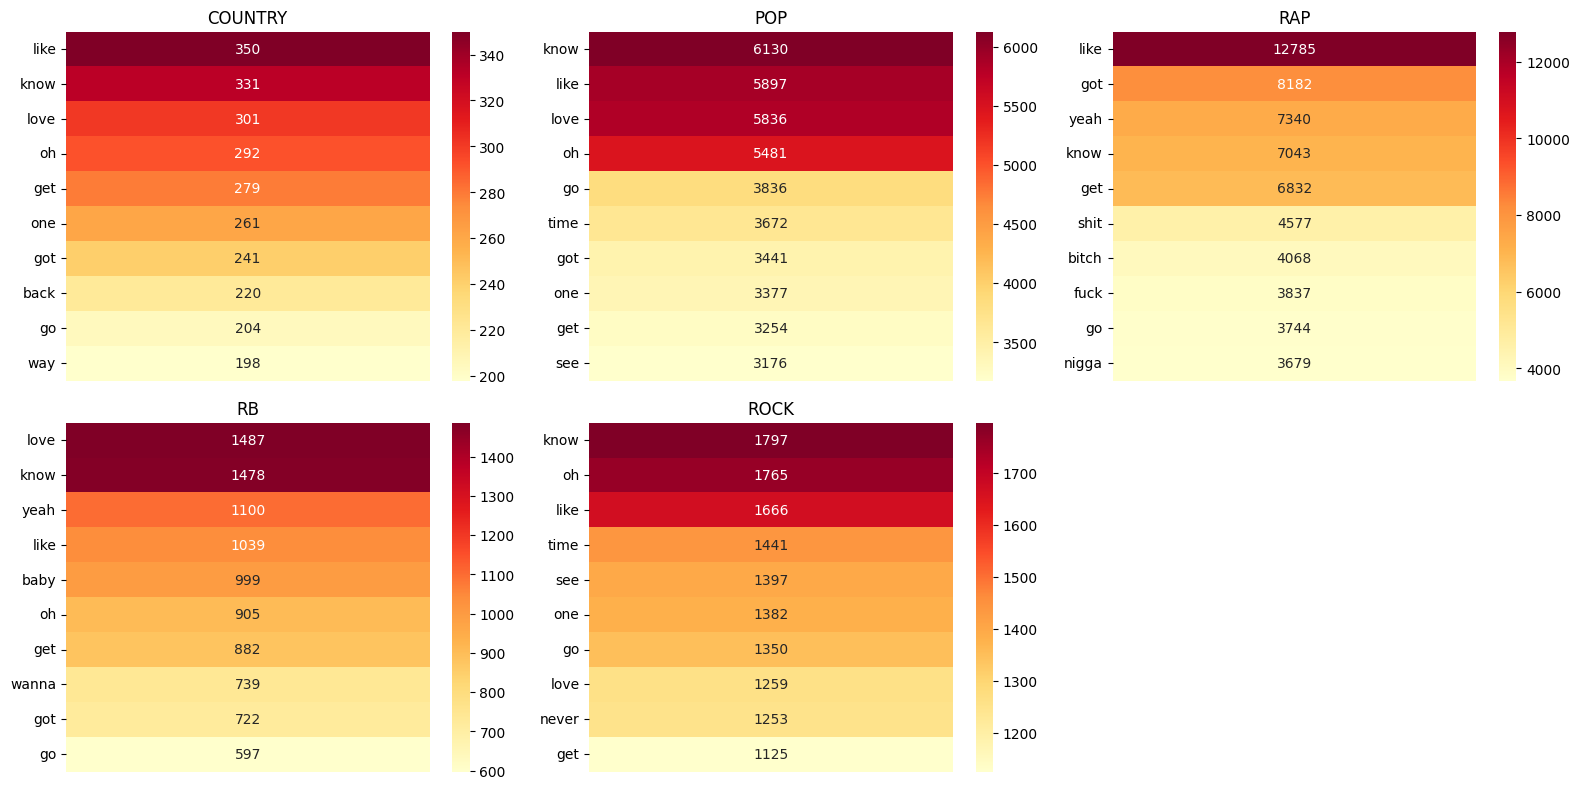

In [30]:
plot_genre_word_heatmaps(freqs, top_n=10)

#### Collocations and bigrams
Let's apply the same approach we used for single words, but this time with bigrams, allowing us to identify recurring patterns across the genres. First, we will examine collocations.

In [31]:
for genre in lyrics.categories():
    print(f"Genre: {genre}")
    collocations = Text(lyrics.words(categories=genre)).collocations(10)

Genre: country
pum pum; rum pum; Thou art; Island Line; mind Troublin; Rock Island;
great Thou; New Orleans; Green grow; Tent City
Genre: pop
feel like; New York; brand new; far away; every day; feels like;
little bit; Even though; say goodbye; Every time
Genre: rap
feel like; brand new; BULLET !!!; !!! BULLET; yeah yeah; yea yea;
little bit; New York; trap house; Geto Boy
Genre: rb
get away; gotta get; Bikini Bottom; thing missing; wanna know; best
friend; Lil Freak; Set sail; Despicable Cat; busy gettin
Genre: rock
New York; fart qweef; little bit; tick tock; York City; Tutti frutti;
Poo shit; shit fart; feels like; mass hysteria


And we do the same for bigrams.

In [32]:
freqs = {}
for genre in lyrics.categories():
    words = [word.lower() for word in lyrics.words(categories=genre)]
    filtered = [word for word in words if word.isalpha() and word not in stop_words] 
    fdist = nltk.FreqDist(list(nltk.bigrams(filtered)))
    freqs[genre] = fdist

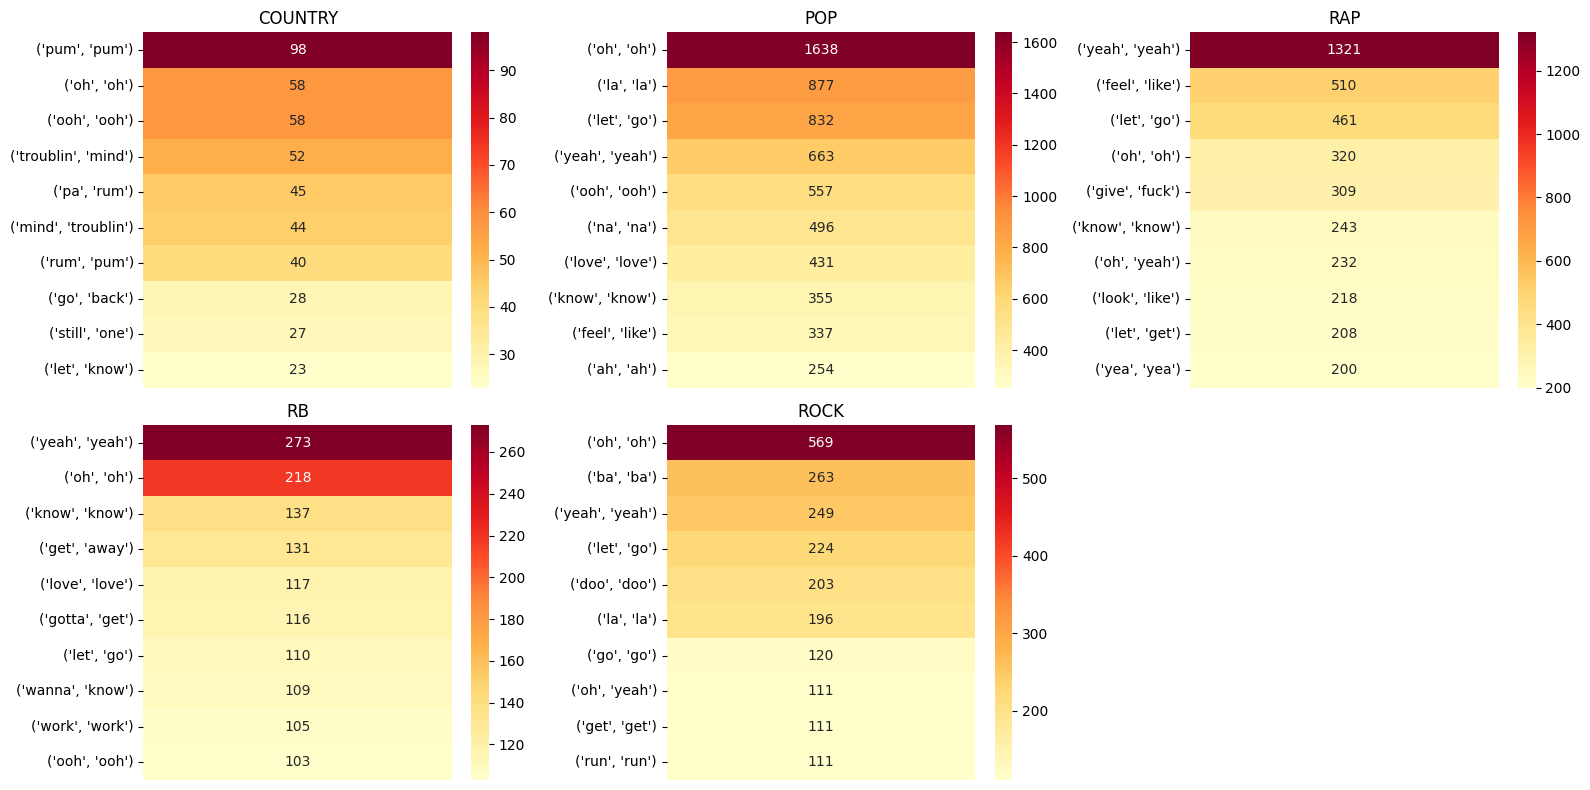

In [33]:
plot_genre_word_heatmaps(freqs, top_n=10)

### Style analysis
We may think that rap is less stylish in terms of the use of modal verbs than pop, but is this really true? Let us check.

In [34]:
cfd = nltk.ConditionalFreqDist(
    (genre, word)
    for genre in lyrics.categories()
    for word in lyrics.words(categories=genre))

In [35]:
genres = lyrics.categories()
modals = ["can", "could", "may", "might", "must", "shall", "should", "will"]
cfd.tabulate(conditions=genres, samples=modals)

           can  could    may  might   must  shall should   will 
country    412    141     33     42     21     11     39    132 
    pop   6152   1862    291    502    390    116    593   2913 
    rap   6098   1391    179    755    262     20    649   1240 
     rb    971    257     18    100     32      6     63    250 
   rock   2472    598    113    150    175     68    200   1426 


#### Modality
Actually, rappers seem to be avid users of modal verbs. However, the number of `rap` songs is significantly greater `rb` and `country` songs. Therefore, let us normalize the counts.

In [36]:
table = []
for genre in cfd.conditions():
    total = cfd[genre].N()
    row = [genre]
    for modal in modals:
        count = cfd[genre][modal]
        normalized = (count / total)
        row.append(round(normalized * 100, 2))
    table.append(row)

In [37]:
columns = ["Genre"]
columns.extend(modals)
df2 = pd.DataFrame(table, columns=columns)
print(df2)

     Genre   can  could   may  might  must  shall  should  will
0  country  0.53   0.18  0.04   0.05  0.03   0.01    0.05  0.17
1      pop  0.53   0.16  0.02   0.04  0.03   0.01    0.05  0.25
2      rap  0.40   0.09  0.01   0.05  0.02   0.00    0.04  0.08
3       rb  0.53   0.14  0.01   0.05  0.02   0.00    0.03  0.14
4     rock  0.54   0.13  0.02   0.03  0.04   0.01    0.04  0.31


As shown above, once scaled, rap lyrics feature fewer modal verbs compared to the other genres, with the exceptions of "can" and "might." Next, we will plot the cumulative word length distributions for the six music genres.

#### Formality and Readability

In [38]:
cfd = nltk.ConditionalFreqDist(
    (genre, len(word))
    for genre in lyrics.categories()
    for word in lyrics.words(categories=genre)
    if len(word) <= 13
)

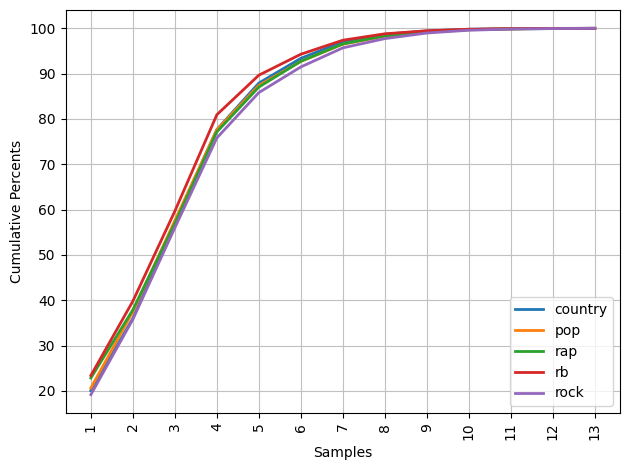

In [39]:
cfd.plot(cumulative=True, percents=True)
plt.tight_layout()
plt.savefig("wordlen.png", dpi=300, bbox_inches='tight')
plt.show()

As demonstrated above, word lengths are similar across the different genres. Notably, over 90% of the words in all songs have a length of 7 or fewer characters. Next, we will analyze sentence length, specifically the number of words per sentence.

In [40]:
cfd = nltk.ConditionalFreqDist(
    (genre, len(sent))
    for genre in lyrics.categories()
    for sent in lyrics.sents(categories=genre)
    if len(sent) <= 50
)

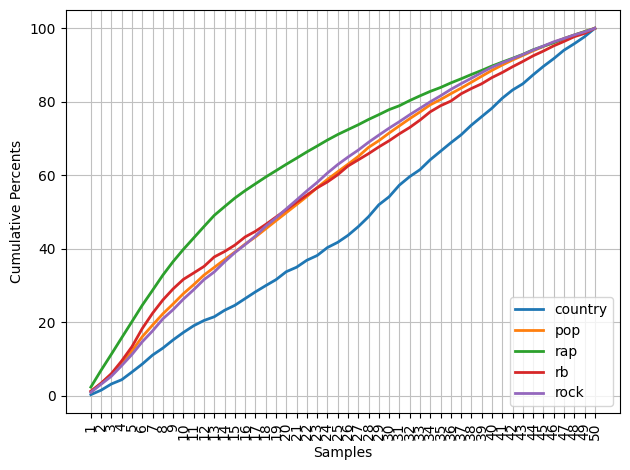

In [41]:
cfd.plot(cumulative=True, percents=True)
plt.tight_layout()
plt.savefig("sentencelen.png", dpi=300, bbox_inches='tight')
plt.show()

#### Hedging and Certainty

In [42]:
hedges = [
    "maybe", "perhaps", "sorta", "kinda", "probably", "possibly", "apparently", "somewhat",
    "seems", "seemed", "seeming", "presumably", "allegedly", "might", "could", "may", "would",
    "almost", "relatively"
]

certainties = [
    "always", "never", "definitely", "certainly", "undeniably", "clearly", "surely", "absolutely",
    "obviously", "forever", "must", "will", "truly", "totally", "indeed", "evidently",
    "unquestionably", "guaranteed"
]

table = []
genres = lyrics.categories()
for genre in genres:
    words = [w.lower() for w in lyrics.words(categories=genre)]
    total = len(words)

    hedge_total = sum(words.count(w) for w in hedges)
    certainty_total = sum(words.count(w) for w in certainties)

    hedge_norm = hedge_total / total * 1e3
    cert_norm = certainty_total / total * 1e3

    table.append([genre, round(hedge_norm, 2), round(cert_norm, 2)])

In [43]:
df2 = pd.DataFrame(table, columns=["Genre", "Hedging", "Certainty"])
print(df2)

     Genre  Hedging  Certainty
0  country     5.29       6.03
1      pop     4.67       7.48
2      rap     3.19       4.34
3       rb     4.39       5.45
4     rock     3.83       8.24


#### Profanity

In [44]:
cfd = nltk.ConditionalFreqDist(
    (genre, word.lower())
    for genre in lyrics.categories()
    for word in lyrics.words(categories=genre))

In [45]:
profanity = ["damn", "crap", "freak", "screw", "bastard", "bloody"]

table = []
for genre in cfd.conditions():
    total = cfd[genre].N()
    row = [genre]
    for w in profanity:
        count = cfd[genre][w]
        normalized = (count / total)
        row.append(round(normalized * 1e6, 2))
    table.append(row)

In [46]:
columns = ["Genre"]
columns.extend(profanity)
df2 = pd.DataFrame(table, columns=columns)
print(df2)

     Genre    damn   crap   freak  screw  bastard  bloody
0  country  180.91   0.00    0.00  25.84     0.00   38.77
1      pop  164.27   5.13   11.98  23.96     7.70   30.80
2      rap  505.43  21.55   71.83  38.53    16.33   27.43
3       rb  589.60   0.00  387.61   5.46     0.00    0.00
4     rock  100.62  26.25   24.06  17.50    32.81   39.37


### Lexical Analysis

In [47]:
tag_categories = {
    "noun": ["NN", "NNS", "NNP", "NNPS"],
    "verb": ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"],
    "adj": ["JJ", "JJR", "JJS"],
    "adv": ["RB", "RBR", "RBS"],
    "pronoun": ["PRP", "PRP$", "WP", "WP$"]
}

table = []
for genre in lyrics.categories():
    words = [w.lower() for w in lyrics.words(categories=genre)]
    tagged = nltk.pos_tag(words)
    
    total = len(tagged)
    counts = {cat: 0 for cat in tag_categories}
    
    for word, tag in tagged:
        for cat, tags in tag_categories.items():
            if tag in tags:
                counts[cat] += 1
    
    row = [genre] + [round((counts[cat] / total) * 100, 2) for cat in tag_categories]
    table.append(row)

In [48]:
columns = ["Genre", "Noun", "Verb", "Adjective", "Adverb", "Pronoun"]
df2 = pd.DataFrame(table, columns=columns)
print(df2)

     Genre   Noun   Verb  Adjective  Adverb  Pronoun
0  country  22.66  18.06       7.98    5.58    10.70
1      pop  22.07  19.17       7.70    5.38    11.52
2      rap  25.56  18.08       8.06    4.47     9.93
3       rb  21.07  19.89       7.72    5.18    12.80
4     rock  22.54  19.14       7.68    5.31    11.03


In [49]:
past_tags = ['VBD', 'VBN']
present_tags = ['VBG', 'VBP', 'VBZ']
future_tags = ['VB']  # base form might suggest future with "will"

table = []
for genre in lyrics.categories():
    words = [w.lower() for w in lyrics.words(categories=genre)]
    tagged = nltk.pos_tag(words)
    
    pos_counts = Counter(tag for word, tag in tagged)
    total_verbs = sum(pos_counts[tag] for tag in past_tags + present_tags + future_tags)
    
    past = sum(pos_counts[tag] for tag in past_tags) / total_verbs * 100
    present = sum(pos_counts[tag] for tag in present_tags) / total_verbs * 100
    future = sum(pos_counts[tag] for tag in future_tags) / total_verbs * 100

    table.append([genre, round(past, 2), round(present, 2), round(future, 2)])

In [50]:
df2 = pd.DataFrame(table, columns=["Genre", "Past", "Present", "Future"])
print(df2)

     Genre   Past  Present  Future
0  country  23.91    47.19   28.90
1      pop  19.13    49.67   31.20
2      rap  22.15    51.01   26.83
3       rb  18.54    50.00   31.46
4     rock  20.75    49.36   29.89


### Sentiment Analysis

In [51]:
sia = SentimentIntensityAnalyzer()

table = []
for genre in lyrics.categories():
    files = lyrics.fileids(categories=genre)
    pos_count = neu_count = neg_count = 0

    for f in files:
        song_raw = lyrics.raw(fileids=f)
        compound = sia.polarity_scores(song_raw)['compound']
        
        if compound >= 0.05:
            pos_count += 1
        elif compound <= -0.05:
            neg_count += 1
        else:
            neu_count += 1

    total = len(files)
    table.append([
        genre,
        100 * pos_count / total,
        100 * neu_count / total,
        100 * neg_count / total
    ])

In [52]:
df2 = pd.DataFrame(table, columns=["Genre", "Positive", "Neutral", "Negative"])
print(df2)

     Genre   Positive   Neutral   Negative
0  country  71.080139  0.348432  28.571429
1      pop  62.155331  1.079963  36.764706
2      rap  40.222522  0.370870  59.406608
3       rb  69.123506  0.597610  30.278884
4     rock  48.600106  1.003698  50.396197


### Building a Classifier

In [289]:
class LyricFeatureExtractor:
    """
    A class to extract features from song lyrics for use with a Naive Bayes classifier.
    The features focus on lexical, stylistic, grammatical, and semantic characteristics.
    """
    
    def __init__(self):
        """Initialize the feature extractor with necessary resources."""
        # Ensure required NLTK resources are available
        try:
            nltk.data.find('tokenizers/punkt')
            nltk.data.find('taggers/averaged_perceptron_tagger')
            nltk.data.find('corpora/stopwords')
        except LookupError:
            nltk.download('punkt')
            nltk.download('averaged_perceptron_tagger')
            nltk.download('stopwords')
        
        # Load resources once during initialization
        self.stop_words = set(stopwords.words('english'))
        self.sia = SentimentIntensityAnalyzer()
        
        # Define word lists for feature extraction
        self.modals = ['can', 'could', 'may', 'might', 'must', 'should', 'will', 'would']
        self.hedging_terms = ['maybe', 'perhaps', 'possibly', 'probably', 'sometimes', 
                             'often', 'usually', 'kinda', 'sorta', 'guess', 'seem']
        self.certainty_terms = ['always', 'never', 'definitely', 'certainly', 'absolutely', 
                               'undoubtedly', 'forever', 'completely', 'surely']
        self.profanity_terms = ['damn', 'crap', 'freak', 'screw', 'bastard', 'bloody']
        
        # POS tag groups
        self.noun_tags = {'NN', 'NNS', 'NNP', 'NNPS'}
        self.verb_tags = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}
        self.adj_tags = {'JJ', 'JJR', 'JJS'}
        self.adv_tags = {'RB', 'RBR', 'RBS'}
        self.pron_tags = {'PRP', 'PRP$', 'WP', 'WP$'}
        self.past_tense_tags = {'VBD', 'VBN'}
        self.present_tense_tags = {'VBG', 'VBP', 'VBZ'}
        self.future_indicators = {'VB'}
    
    def preprocess_text(self, text):
        """Preprocess the text by lowercasing and tokenizing."""
        text = text.lower()
        tokens = nltk.word_tokenize(text)
        words = [word for word in tokens if word.isalpha()]
        content_words = [word for word in words if word not in self.stop_words]
        
        # Get sentences for length analysis
        sentences = re.split(r'[.!?]+', text)
        sentences = [s.strip() for s in sentences if s.strip()]
        
        return {
            'tokens': tokens,
            'words': words,
            'content_words': content_words,
            'sentences': sentences
        }
    
    def extract_lexical_features(self, processed_text):
        """Extract lexical diversity and complexity features."""
        words = processed_text['words']
        if not words:
            return {'lexical_diversity_level': 'low', 'avg_word_length_level': 'low'}
        
        word_count = len(words)
        unique_words = len(set(words))
        
        lexical_diversity = unique_words / word_count if word_count else 0
        avg_word_length = sum(len(word) for word in words) / word_count if word_count else 0
        
        return {
            'lexical_diversity_level': self._categorize_lexical_diversity(lexical_diversity),
            'avg_word_length_level': self._categorize_avg_word_length(avg_word_length)
        }
    
    def extract_stylistic_features(self, processed_text):
        """Extract stylistic features including modal usage, sentence structure, and tone indicators."""
        words = processed_text['words']
        sentences = processed_text['sentences']
        
        if not words:
            return {}
        
        features = {}
        word_count = len(words)
        
        # Modal usage
        for modal in self.modals:
            ratio = words.count(modal) / word_count
            features[f'modal_{modal}'] = self._categorize_ratio(ratio)
        
        # Sentence length
        if sentences:
            avg_sentence_length = sum(len(nltk.word_tokenize(s)) for s in sentences) / len(sentences)
            features['avg_sentence_length'] = self._categorize_sentence_length(avg_sentence_length)
        else:
            features['avg_sentence_length'] = 'short'
        
        # Hedging and certainty
        hedging_ratio = sum(words.count(term) for term in self.hedging_terms) / word_count
        certainty_ratio = sum(words.count(term) for term in self.certainty_terms) / word_count
        features['hedging'] = self._categorize_ratio(hedging_ratio)
        features['certainty'] = self._categorize_ratio(certainty_ratio)
        
        # Profanity
        profanity_ratio = sum(words.count(term) for term in self.profanity_terms) / word_count
        features['profanity'] = self._categorize_ratio(profanity_ratio)
        
        return features
    
    def extract_grammatical_features(self, processed_text):
        """Extract grammatical features based on parts of speech."""
        words = processed_text['words']
        if not words:
            return {}
        
        pos_tags = nltk.pos_tag(words)
        pos_counts = Counter(tag for _, tag in pos_tags)
        total_tags = len(pos_tags)
        
        features = {}
        
        # Calculate POS ratios
        if total_tags:
            features['nouns'] = self._categorize_ratio(
                sum(pos_counts[tag] for tag in self.noun_tags if tag in pos_counts) / total_tags
            )
            features['verbs'] = self._categorize_ratio(
                sum(pos_counts[tag] for tag in self.verb_tags if tag in pos_counts) / total_tags
            )
            features['adjectives'] = self._categorize_ratio(
                sum(pos_counts[tag] for tag in self.adj_tags if tag in pos_counts) / total_tags
            )
            features['adverbs'] = self._categorize_ratio(
                sum(pos_counts[tag] for tag in self.adv_tags if tag in pos_counts) / total_tags
            )
            features['pronouns'] = self._categorize_ratio(
                sum(pos_counts[tag] for tag in self.pron_tags if tag in pos_counts) / total_tags
            )
            
            # Tense indicators
            past_tense_ratio = sum(pos_counts[tag] for tag in self.past_tense_tags if tag in pos_counts) / total_tags
            present_tense_ratio = sum(pos_counts[tag] for tag in self.present_tense_tags if tag in pos_counts) / total_tags
            future_tense_ratio = sum(pos_counts[tag] for tag in self.future_indicators if tag in pos_counts) / total_tags
            
            # Determine dominant tense
            tense_ratios = {
                'past': past_tense_ratio,
                'present': present_tense_ratio,
                'future': future_tense_ratio
            }
            features['dominant_tense'] = max(tense_ratios, key=tense_ratios.get)
        
        return features
    
    def extract_semantic_features(self, text):
        """Extract semantic features including sentiment and key topics."""
        sentiment = self.sia.polarity_scores(text)
        
        features = {
            'sentiment': self._categorize_sentiment(sentiment['compound']),
            'is_positive': sentiment['pos'] > sentiment['neg'],
            'sentiment_intensity': 'high' if abs(sentiment['compound']) > 0.5 else 'medium' if abs(sentiment['compound']) > 0.2 else 'low'
        }
        
        return features
    
    def extract_topic_features(self, processed_text):
        """Extract features related to topics and themes based on frequent words."""
        content_words = processed_text['content_words']
        if not content_words:
            return {}
        
        # Get most frequent content words for topic identification
        word_counts = Counter(content_words)
        features = {}
        
        # Extract top 5 most frequent words as potential topic indicators
        for word, count in word_counts.most_common(5):
            if count >= 2:  # Only include if word appears multiple times
                features[f'topic_{word}'] = True
        
        return features
    
    def extract_features(self, lyrics):
        """Main method to extract all features from the lyrics."""
        if not lyrics or not isinstance(lyrics, str):
            return {}
        
        # Preprocess the text
        processed_text = self.preprocess_text(lyrics)
        
        # Extract different feature types
        features = {}
        features.update(self.extract_lexical_features(processed_text))
        features.update(self.extract_stylistic_features(processed_text))
        features.update(self.extract_grammatical_features(processed_text))
        features.update(self.extract_semantic_features(lyrics))
        #features.update(self.extract_topic_features(processed_text))
        
        return features
    
    # Helper methods for categorizing continuous values into discrete bins
    def _categorize_lexical_diversity(self, value):
        """Categorize lexical diversity into discrete levels."""
        if value < 0.4:
            return 'low'
        elif value < 0.6:
            return 'medium'
        else:
            return 'high'
    
    def _categorize_avg_word_length(self, value):
        """Categorize average word length into discrete levels."""
        if value < 4.0:
            return 'short'
        elif value < 5.5:
            return 'medium'
        else:
            return 'long'
    
    def _categorize_sentence_length(self, value):
        """Categorize average sentence length into discrete levels."""
        if value < 8:
            return 'short'
        elif value < 15:
            return 'medium'
        else:
            return 'long'
    
    def _categorize_ratio(self, value):
        """Categorize ratio values into discrete levels."""
        if value < 0.05:
            return 'low'
        elif value < 0.15:
            return 'medium'
        else:
            return 'high'
    
    def _categorize_sentiment(self, value):
        """Categorize sentiment compound score into discrete sentiment classes."""
        if value <= -0.05:
            return 'negative'
        elif value >= 0.05:
            return 'positive'
        else:
            return 'neutral'

In [290]:
def prepare_classifier_data(corpus, feature_extractor):
    # Create feature sets from the corpus
    feature_sets = []
    
    for category in corpus.categories():
        for fileid in corpus.fileids(category):
            lyrics_text = corpus.raw(fileid)
            features = feature_extractor.extract_features(lyrics_text)
            feature_sets.append((features, category))
    
    # Shuffle the feature sets
    # A seed is set for reproducibility. However, the article was written without
    # using a seed. Due to the use of random shuffling without a fixed seed, the
    # results reported may vary across different runs.  
    random.seed(2025) # for reproducibility
    random.shuffle(feature_sets)
    
    # Split into training and testing sets (80% training, 20% testing)
    train_size = int(0.8 * len(feature_sets))
    train_set = feature_sets[:train_size]
    test_set = feature_sets[train_size:]
    
    return train_set, test_set

Prepare data for classification.

In [291]:
extractor = LyricFeatureExtractor()
train_set, test_set = prepare_classifier_data(lyrics, extractor)

Train the classifier.

In [292]:
classifier = NaiveBayesClassifier.train(train_set)

Evaluate the classifier.

In [293]:
accuracy = nltk.classify.accuracy(classifier, test_set)
print(f"Classifier accuracy: {accuracy:.4f}")

Classifier accuracy: 0.4940


Show most informative features.

In [294]:
classifier.show_most_informative_features(10)

Most Informative Features
              modal_will = 'medium'         rock : rap    =     18.2 : 1.0
               modal_can = 'medium'          pop : rap    =      8.9 : 1.0
                   nouns = 'medium'           rb : rap    =      6.6 : 1.0
             modal_could = 'medium'       countr : rock   =      6.5 : 1.0
                   nouns = 'low'              rb : rap    =      5.9 : 1.0
               profanity = 'medium'           rb : rap    =      5.9 : 1.0
   avg_word_length_level = 'medium'         rock : rb     =      5.8 : 1.0
               certainty = 'medium'          pop : rap    =      4.8 : 1.0
     avg_sentence_length = 'medium'          pop : countr =      4.3 : 1.0
                   verbs = 'medium'       countr : rb     =      4.2 : 1.0


Print confusion matrix.

In [295]:
true_labels = []
predicted_labels = []

for feats, label in test_set:
    true_labels.append(label)
    predicted_labels.append(classifier.classify(feats))

cm = ConfusionMatrix(true_labels, predicted_labels)
print(cm)

        |   c                 |
        |   o                 |
        |   u                 |
        |   n               r |
        |   t   p   r       o |
        |   r   o   a   r   c |
        |   y   p   p   b   k |
--------+---------------------+
country |  <.> 42  10   .   1 |
    pop |   .<610>223   1  48 |
    rap |   . 239<338>  .  12 |
     rb |   .  79  24  <.>  . |
   rock |   . 229 104   . <40>|
--------+---------------------+
(row = reference; col = test)



Precision, recall and f-measure per genre.

In [297]:
true_sets = collections.defaultdict(set)
pred_sets = collections.defaultdict(set)

for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)):
    true_sets[true].add(i)
    pred_sets[pred].add(i)

table = []
for genre in lyrics.categories():
    precision = nltk.precision(true_sets[genre], pred_sets[genre])
    recall = nltk.recall(true_sets[genre], pred_sets[genre])
    f_measure = nltk.f_measure(true_sets[genre], pred_sets[genre])
    table.append([genre, round(precision or 0, 2), round(recall or 0, 2), round(f_measure or 0, 2)])

In [298]:
df2 = pd.DataFrame(table, columns=["Genre", "Precision", "Recall", "F-measure"])
print(df2)

     Genre  Precision  Recall  F-measure
0  country       0.00    0.00       0.00
1      pop       0.51    0.69       0.59
2      rap       0.48    0.57       0.52
3       rb       0.00    0.00       0.00
4     rock       0.40    0.11       0.17


### Generating random text with n-grams
Let us generate some text using a bigram model, and let us see how it works depending on the genre with which it is trained.

In [53]:
class BigramModel:
    def __init__(self, text):
        self.text = text

    def train(self):
        self.bigrams = nltk.bigrams(self.text)
        self.cfd = nltk.ConditionalFreqDist(self.bigrams)
    
    def generate(self, word, num=1):
        gen = word
        for _ in range(num):
            try:
                pred = self.cfd[word].max()
                gen += " " + pred
                word = pred
            except ValueError:
                break
        return gen

In [54]:
word = "hello"
for genre in lyrics.categories():
    bigram_model = BigramModel(lyrics.words(categories=genre))
    bigram_model.train()
    pred = bigram_model.generate(word, num=1)
    print(f"Genre {genre}: {pred}")

Genre country: hello backroad
Genre pop: hello ,
Genre rap: hello to
Genre rb: hello with
Genre rock: hello '


Let us do the same with a trigram model.

In [55]:
class TrigramModel:
    def __init__(self, text):
        self.text = text

    def train(self):
        self.trigrams = nltk.trigrams(self.text)
        self.cfd = nltk.ConditionalFreqDist(((w1, w2), w3) for w1, w2, w3 in self.trigrams)
    
    def generate(self, word1, word2, num=1):
        gen = word1 + " " + word2
        for _ in range(num):
            try:
                pred = self.cfd[(word1, word2)].max()
                gen += " " + pred
                word1, word2 = word2, pred
            except ValueError:
                break            
        return gen

In [58]:
words = ["i", "am"]
for genre in lyrics.categories():
    trigram_model = TrigramModel(lyrics.words(categories=genre))
    trigram_model.train()
    pred = trigram_model.generate(words[0], words[1], num=3)
    print(f"Genre {genre}: {pred}")

Genre country: i am
Genre pop: i am set free oh
Genre rap: i am the one that
Genre rb: i am not a god
Genre rock: i am is fire If
